# Flexibility under Uncertainty

The previous chapter only modelled a single scenario where flexibility was
employed. In this chapter, we follow {cite}`farevuu2018` (Chapter 9) in
assessing how flexibility can be used to manage, and benefit from, uncertainty.

## Multiple Market Scenarios
If we can produce one future market scenario, we can also produce many. To
incorporate our uncertainty about how future scenarios may unfold, we derive
`Market` input parameters by sampling from probability distributions that
we suspect are realistic for the market in question.

### Market Parameters from Sampling Distributions of their Likelihoods
*Rangekeeper* provides alternate methods for `Market` `dynamics` modules that
take probability distributions as inputs, rather than single values. These
methods also require us to specify how many iterations (runs, or simulations) we
will produce.

Begin with importing required libraries and configuring our context:

In [1]:
import locale

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns

import rangekeeper as rk

In [2]:
locale.setlocale(locale.LC_ALL, 'en_AU')
units = rk.measure.Index.registry
currency = rk.measure.register_currency(registry=units)

Specify how many iterations (scenarios) we will produce. This matches the number
of samples we will take from the probability distributions:

In [3]:
iterations = 2000

We also need to define the overall `Span` of the `Market`:

In [4]:
frequency = rk.duration.Type.YEAR
num_periods = 25
span = rk.duration.Span.from_duration(
    name="Span",
    date=pd.Timestamp(2000, 1, 1),
    duration=frequency,
    amount=num_periods)
sequence = span.to_sequence(frequency=frequency)

#### Overall Trend
Following how {cite}`farevuu2018` construct market simulations, a *Rangekeeper*
`Market` `Trend` can sample from distributions defining the growth rate (trend)
and initial rent value.

For initial (rent) value, typically values would not be more than 0.05 or 0.1,
at most. Initial rents should be able to be estimated pretty accurately in the
realistic pro-forma, especially for existing buildings.

The growth rate distribution reflects uncertainty in the long-run trend growth
rate (that applies throughout the entire scenario. In {cite}`farevuu2018`, this
is modeled as a triangular distribution (though *Rangekeeper* provides other
distributions easily), and the half-range should typically be a small value, at
most .01 or .02, unless there is great uncertainty in the long-run average
growth rate in the economy (such as perhaps in some emerging market countries),
or if one is modeling nominal values and there is great uncertainty about what
the future rate of inflation will be (but in such cases it is better to model
real values, net of inflation anyway).

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)

First we define the distributions:

In [5]:
growth_rate_dist = rk.distribution.Symmetric(
    type=rk.distribution.Type.TRIANGULAR,
    mean=-.0005,
    residual=.005)
initial_value_dist = rk.distribution.Symmetric(
    type=rk.distribution.Type.TRIANGULAR,
    mean=.05,
    residual=.005)

We now produce the resultant `Trend`s:

In [6]:
cap_rate = .05

trends = rk.dynamics.trend.Trend.from_likelihoods(
    sequence=sequence,
    cap_rate=cap_rate,
    growth_rate_dist=growth_rate_dist,
    initial_value_dist=initial_value_dist,
    iterations=iterations)

We can check that the `Trend`s have been produced as expected:

<Axes: ylabel='Count'>

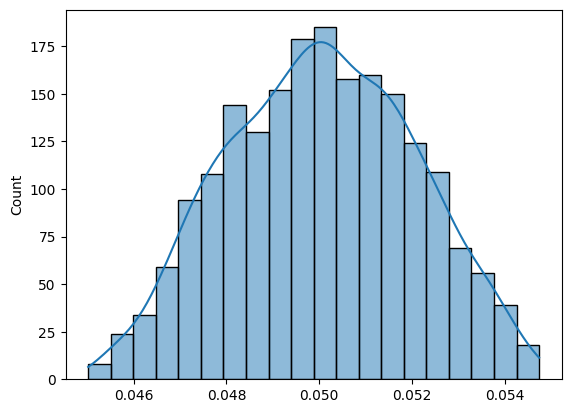

In [7]:
initial_values = [trend.initial_value for trend in trends]
sns.histplot(
    data=initial_values,
    bins=20,
    kde=True)

#### Volatility
Volatility inputs do not require sampling from distributions, but we will be
producing multiple `Volatility` objects, one for each `Trend`:

In [8]:
volatility_per_period = .1
autoregression_param = .2
mean_reversion_param = .3

volatilities = rk.dynamics.volatility.Volatility.from_trends(
    sequence=sequence,
    trends=trends,
    volatility_per_period=volatility_per_period,
    autoregression_param=autoregression_param,
    mean_reversion_param=mean_reversion_param)

#### Cyclicality
{cite}`farevuu2018` document multiple means to incorporate estimations of market
cycle parameters into a market simulation. Here we replicate the distribution
parameters for use in *Rangekeeper*.

We are agnostic about where the market currently is in the cycle, and want
to simulate all possibilities; thus the Space (Rent) Cycle Phase Proportion (of
its period) is sampled from a uniform distribution defaulted to a range between
0 & 1):

In [9]:
space_cycle_phase_prop_dist = rk.distribution.Uniform()

The Space (Rent) Cycle Period is a random sample between 10 & 20 years:

In [10]:
space_cycle_period_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=15,
    residual=5)

The Space (Rent) Cycle peak-to-trough Height is set at 50% (see `residual` fixed
to 0):

In [11]:
space_cycle_height_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=.5,
    residual=0)

The Asset (Cap Rate) Cycle Phase differs from the Space Cycle by between -1/10th
and 1/10th of the Space Cycle Period:

In [12]:
asset_cycle_phase_diff_prop_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=0,
    residual=.1)

The Asset (Cap Rate) Cycle Period in between -1 and 1 year different to that of
the Space (Rent) Cycle's

In [13]:
asset_cycle_period_diff_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=0,
    residual=1)

The Asset (Cap Rate) Cycle Amplitude is fixed to 2%:

In [14]:
asset_cycle_amplitude_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=.02,
    residual=0.)

For both the Space and Asset Cycles, we remove any cycle asymmetries, in order
to align with {cite}`farevuu2018`'s spreadsheet for Chapters 8, 9, 10. In future
classes (and possibly future editions), they incorporate cycle asymmetries.

In [15]:
space_cycle_asymmetric_parameter_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=0,
    residual=0.)
asset_cycle_asymmetric_parameter_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=0,
    residual=0.)

We now produce the resultant `Cycle`s:

In [16]:
cyclicalities = rk.dynamics.cyclicality.Cyclicality.from_likelihoods(
    sequence=sequence,
    space_cycle_phase_prop_dist=space_cycle_phase_prop_dist,
    space_cycle_period_dist=space_cycle_period_dist,
    space_cycle_height_dist=space_cycle_height_dist,
    asset_cycle_phase_diff_prop_dist=asset_cycle_phase_diff_prop_dist,
    asset_cycle_period_diff_dist=asset_cycle_period_diff_dist,
    asset_cycle_amplitude_dist=asset_cycle_amplitude_dist,
    space_cycle_asymmetric_parameter_dist=space_cycle_asymmetric_parameter_dist,
    asset_cycle_asymmetric_parameter_dist=asset_cycle_asymmetric_parameter_dist,
    iterations=iterations)

#### Noise & Black Swan
Noise & Black Swan inputs do not require sampling from distributions:

In [17]:
noise = rk.dynamics.noise.Noise(
    sequence=sequence,
    noise_dist=rk.distribution.Symmetric(
        type=rk.distribution.Type.TRIANGULAR,
        mean=0.,
        residual=.1))
black_swan = rk.dynamics.black_swan.BlackSwan(
    sequence=sequence,
    likelihood=.05,
    dissipation_rate=mean_reversion_param,
    probability=rk.distribution.Uniform(),
    impact=-.25)

### Markets
Now we can integrate the previous constructs into multiple `Market` simulations:

In [18]:
markets = rk.dynamics.market.Market.from_likelihoods(
    sequence=sequence,
    trends=trends,
    volatilities=volatilities,
    cyclicalities=cyclicalities,
    noise=noise,
    black_swan=black_swan)

As an example, here is one of the `Market`s (drawn from the `markets` by a random integer):

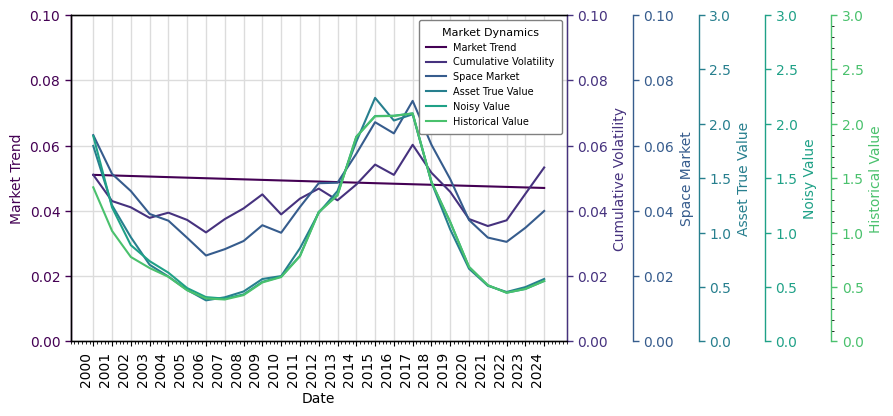

In [19]:
import random
sample_market = markets[random.Random(0).randint(0, iterations - 1)]
table = rk.flux.Stream(
    name='Market Dynamics',
    flows=[
        sample_market.trend,
        sample_market.volatility.volatility,
        sample_market.volatility.autoregressive_returns,
        sample_market.volatility,
        sample_market.cyclicality.space_waveform,
        sample_market.space_market,
        sample_market.cyclicality.asset_waveform,
        sample_market.asset_market,
        sample_market.asset_true_value,
        sample_market.space_market_price_factors,
        sample_market.noisy_value,
        sample_market.historical_value,
        sample_market.implied_rev_cap_rate,
        sample_market.returns
        ],
    frequency=frequency)
table.plot(
        flows={
            'Market Trend': (0, .1),
            'Cumulative Volatility': (0, .1),
            'Space Market': (0, .1),
            'Asset True Value': (0, 3),
            'Noisy Value': (0, 3),
            'Historical Value': (0, 3)
            }
    )

## Comparing Models
From {cite}`farevuu2018`: to obtain the value of flexibility, we compare the
project utilizing flexibility against a base case or alternative that lacks the
particular flexibility or rule we are evaluating.
We must expose the inflexible case to the same independent, random future
scenarios as the flexible case. We must compute the outcomes for the two cases,
inflexible and flexible, under exactly the same scenarios of pricing factor
realizations. We can then compare the results of both the inflexible and
flexible cases, not only against the (single‐number) traditional pro forma
metrics, but also side by side against each other for the entire distribution of
possible (ex‐post) outcomes, recognizing the uncertainty and price dynamics that
realistically exist.

### Inflexible (Base) Model
Define the Base Model as we did the Ex-Post Inflexible Model in the previous
section:

In [20]:
params = {
    'start_date': pd.Timestamp('2001-01-01'),
    'num_periods': 10,
    'frequency': rk.duration.Type.YEAR,
    'acquisition_cost': -1000 * currency.units,
    'initial_income': 100 * currency.units,
    'growth_rate': 0.02,
    'vacancy_rate': 0.05,
    'opex_pgi_ratio': 0.35,
    'capex_pgi_ratio': 0.1,
    'exit_caprate': 0.05,
    'discount_rate': 0.07
    }

In [21]:
class BaseModel:
    def __init__(self) -> None:
        pass
    def set_params(self, params: dict) -> None:
        self.params = params
    def set_market(self, market: rk.dynamics.market.Market) -> None:
        self.market = market
    def init_spans(self):
        self.calc_span = rk.duration.Span.from_duration(
            name='Span to Calculate Reversion',
            date=self.params['start_date'],
            duration=self.params['frequency'],
            amount=self.params['num_periods'] + 1)
        self.acq_span = rk.duration.Span.from_duration(
            name='Acquisition Span',
            date=rk.duration.offset(
                date=self.params['start_date'],
                amount=-1,
                duration=self.params['frequency']),
            duration=self.params['frequency'])
        self.span = self.calc_span.extend(
            name='Span',
            amount=-1,
            duration=self.params['frequency'])
        self.reversion_span = self.span.extend(
            name='Reversion Span',
            amount=self.params['num_periods'] - 1,
            duration=self.params['frequency'],
            bound='start')
    def calc_acquisition(self):
        self.acquisition = rk.flux.Flow.from_projection(
            name='Acquisition',
            value=self.params['acquisition_cost'],
            proj=rk.projection.Distribution(
                form=rk.distribution.Uniform(),
                sequence=self.acq_span.to_sequence(frequency=self.params['frequency'])),
            units=currency.units)
    def calc_egi(self):
        pgi = rk.flux.Flow.from_projection(
            name='Potential Gross Income',
            value=self.params['initial_income'],
            proj=rk.projection.Extrapolation(
                form=rk.extrapolation.Compounding(
                    rate=self.params['growth_rate']),
                sequence=self.calc_span.to_sequence(frequency=self.params['frequency'])),
            units=currency.units)

        # Construct a Stream that multiplies the Base Model's PGI by the
        # simulated Market's Space Market factors
        self.pgi = (rk.flux.Stream(
            name='Potential Gross Income',
            flows=[
                pgi,
                self.market.space_market_price_factors.trim_to_span(self.calc_span)
                ],
            frequency=self.params['frequency'])
                .product(registry=rk.measure.Index.registry))

        self.vacancy = rk.flux.Flow(
            name='Vacancy Allowance',
            movements=self.pgi.movements * -self.params['vacancy_rate'],
            units=currency.units)
        self.egi = (rk.flux.Stream(
            name='Effective Gross Income',
            flows=[self.pgi, self.vacancy],
            frequency=self.params['frequency'])
                .sum())
    def calc_noi(self):
        self.opex = (rk.flux.Flow(
            name='Operating Expenses',
            movements=self.pgi.movements * self.params['opex_pgi_ratio'],
            units=currency.units)
                .negate())
        self.noi = (rk.flux.Stream(
            name='Net Operating Income',
            flows=[self.egi, self.opex],
            frequency=self.params['frequency'])
                .sum())
    def calc_ncf(self):
        self.capex = (rk.flux.Flow(
            name='Capital Expenditures',
            movements=self.pgi.movements * self.params['capex_pgi_ratio'],
            units=currency.units)
                .negate())
        self.net_cf = (rk.flux.Stream(
            name='Net Annual Cashflow',
            flows=[self.noi, self.capex],
            frequency=self.params['frequency'])
                .sum())
    def calc_reversion(self):
            # Construct the Reversions using the simulated Market's Asset Market
            # factors (cap rates):
            self.reversions = (rk.flux.Flow(
                name='Reversions',
                movements=self.net_cf.movements.shift(periods=-1).dropna() /
                          self.market.implied_rev_cap_rate.movements,
                units=currency.units)
                    .trim_to_span(span=self.span))

            self.reversion = self.reversions.trim_to_span(
                span=self.reversion_span,
                name='Reversion')
            self.pbtcfs = rk.flux.Stream(
                name='PBTCFs',
                flows=[
                    self.net_cf.trim_to_span(span=self.span),
                    self.reversions.trim_to_span(span=self.reversion_span)
                    ],
                frequency=self.params['frequency'])
    def calc_metrics(self):
        pvs = []
        irrs = []
        for period in self.net_cf.trim_to_span(span=self.span).movements.index:
            cumulative_net_cf = self.net_cf.trim_to_span(
                span=rk.duration.Span(
                    name='Cumulative Net Cashflow Span',
                    start_date=self.params['start_date'],
                    end_date=period))
            reversion = rk.flux.Flow(
                movements=self.reversions.movements.loc[[period]],
                units=currency.units)
            cumulative_net_cf_with_rev = rk.flux.Stream(
                name='Net Cashflow with Reversion',
                flows=[
                    cumulative_net_cf,
                    reversion
                    ],
                frequency=self.params['frequency'])
            pv = cumulative_net_cf_with_rev.sum().pv(
                name='Present Value',
                frequency=self.params['frequency'],
                rate=self.params['discount_rate'])
            pvs.append(pv.collapse().movements)

            incl_acq = rk.flux.Stream(
                name='Net Cashflow with Reversion and Acquisition',
                flows=[cumulative_net_cf_with_rev.sum(), self.acquisition],
                frequency=self.params['frequency'])

            irrs.append(round(incl_acq.sum().irr(), 4))

        self.pvs = rk.flux.Flow(
            name='Present Values',
            movements=pd.concat(pvs),
            units=currency.units)
        self.irrs = rk.flux.Flow(
            name='Internal Rates of Return',
            movements=pd.Series(irrs, index=self.pvs.movements.index),
            units=None)
    def generate(self):
        self.init_spans()
        self.calc_acquisition()
        self.calc_egi()
        self.calc_noi()
        self.calc_ncf()
        self.calc_reversion()
        self.calc_metrics()

For each `Market`, we then run the Base Model.
To speed this up we can use multiprocessing, so we need to import and configure
a few libraries:

In [22]:
import os
from typing import List
import multiprocess
import pint
pint.set_application_registry(rk.measure.Index.registry)

In [23]:
inflex_scenarios = []
for market in markets:
    scenario = BaseModel()
    scenario.set_params(params.copy())
    scenario.set_market(market)
    inflex_scenarios.append(scenario)

In [24]:
def generate(scenario):
    scenario.generate()
    return scenario
inflex_scenarios = multiprocess.Pool(os.cpu_count()).map(
    generate,
    inflex_scenarios)

### Flexible Model
Similarly, we set up the Flexible Model with our `Policy`:

In [25]:
def exceed_pricing_factor(state: rk.flux.Flow) -> List[bool]:
    threshold = 1.2
    result = []
    for i in range(state.movements.index.size):
        if any(result):
            result.append(False)
        else:
            if i < 1:
                result.append(False)
            else:
                if state.movements.iloc[i] > threshold:
                    result.append(True)
                else:
                    result.append(False)
    return result

def adjust_hold_period(
        model: object,
        decisions: List[bool]) -> object:
    # Get the index of the decision flag:
    try:
        idx = decisions.index(True)
    except ValueError:
        idx = len(decisions)

    # Adjust the Model's holding period:
    policy_params = model.params.copy()
    policy_params['num_periods'] = idx

    # Re-run the Model with updated params:
    model.set_params(policy_params)
    model.generate()
    return model

stop_gain_resale_policy = rk.policy.Policy(
    condition=exceed_pricing_factor,
    action=adjust_hold_period)

And we run the Flexible Model for each `Market`:

In [26]:
policy_args = [(scenario.market.space_market_price_factors, scenario) for scenario in inflex_scenarios]
flex_scenarios = multiprocess.Pool(os.cpu_count()).map(
    stop_gain_resale_policy.execute,
    policy_args)

### Results
We can now compare the results of the Base and Flexible Models with some
descriptive statistics

In [27]:
import scipy.stats as ss

#### Time 0 Present Values at OCC

In [28]:
inflex_pvs = pd.Series([scenario.pvs.movements.iloc[-1] for scenario in inflex_scenarios])
flex_pvs = pd.Series([scenario.pvs.movements.iloc[-1] for scenario in flex_scenarios])
diff_pvs = flex_pvs - inflex_pvs

pvs = pd.DataFrame({
    'Inflexible': inflex_pvs,
    'Flexible': flex_pvs,
    'Difference': diff_pvs})
pvs.describe()

,Inflexible,Flexible,Difference
count,2000.000000,2000.000000,2000.000000
mean,1072.543062,1435.861724,363.318662
std,340.731724,409.011430,554.795233
min,522.375230,539.226862,-1399.941700
25%,795.217613,1199.181323,-48.021396
50%,985.363016,1453.376384,376.094430
75%,1312.603936,1713.210422,752.969720
max,2399.276122,2697.902717,1853.843909


At a high level, we can see from the mean and median (50th percentile) results that the Flexible Model produces a higher PV than the Inflexible Model (by about $400. 
However, there still is a significant distortion of the distributions from normal, as can be seen in the skewness and kurtosis statistics.

In [29]:
pvs.skew()

Inflexible    0.784544
Flexible     -0.265706
Difference   -0.017136
dtype: float64

In [30]:
pvs.kurtosis()

Inflexible   -0.032361
Flexible     -0.116688
Difference   -0.582599
dtype: float64

In [31]:
print('PV Diffs t-stat: \n{}'.format(
    ss.ttest_1samp(diff_pvs, 0)))

PV Diffs t-stat: 
TtestResult(statistic=np.float64(29.286669325536923), pvalue=np.float64(3.439977994505339e-157), df=np.int64(1999))


##### PVs Cumulative Distribution ('Target Curves')

To get a better idea of just how the Flexible Model outperforms the Inflexible Model, we can plot their distributions of outcomes

###### Present Values

<Axes: ylabel='Count'>

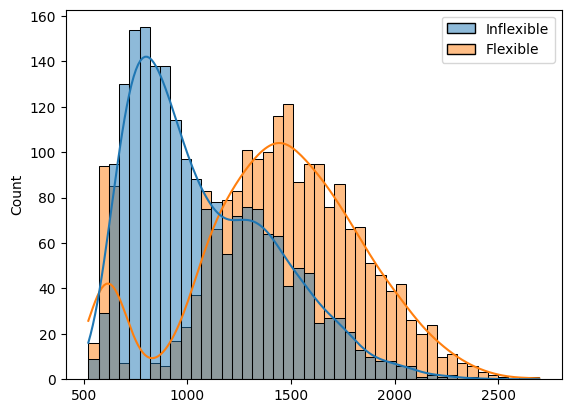

In [32]:
sns.histplot(
    data=pvs.drop(columns=['Difference']),
    binwidth=50,
    kde=True
    )

To make reading the plot easier and identify just how and when the Flexible model outperforms the Inflexible, we can also plot the cumulative distribution of the PVs:

<Axes: ylabel='Proportion'>

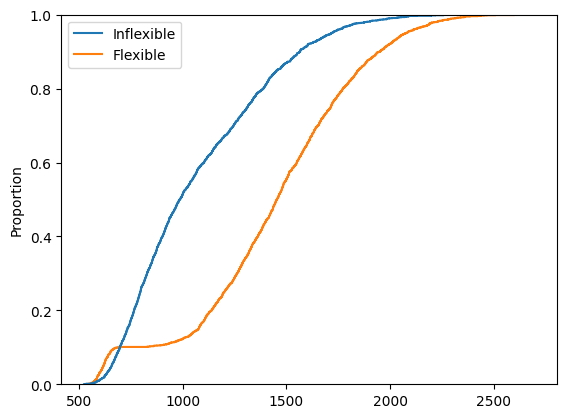

In [33]:
sns.ecdfplot(
    data=pvs.drop(columns=['Difference']))

#### Realized IRR at Market Value Price

In [34]:
inflex_irrs = pd.Series([scenario.irrs.movements.iloc[-1] for scenario in inflex_scenarios])
flex_irrs = pd.Series([scenario.irrs.movements.iloc[-1] for scenario in flex_scenarios])
diff_irrs = flex_irrs - inflex_irrs

irrs = pd.DataFrame({
    'Inflexible': inflex_irrs,
    'Flexible': flex_irrs,
    'Difference': diff_irrs})
irrs.describe()

,Inflexible,Flexible,Difference
count,2000.000000,2000.000000,2000.000000
mean,0.071297,0.284939,0.213642
std,0.040244,0.346125,0.358724
min,-0.021319,-0.026725,-0.158996
25%,0.038459,0.092533,0.000000
50%,0.068040,0.135949,0.059050
75%,0.104341,0.295923,0.246092
max,0.177128,1.886756,1.841387


In [35]:
irrs.skew()

Inflexible    0.157770
Flexible      2.020676
Difference    1.942266
dtype: float64

In [36]:
irrs.kurtosis()

Inflexible   -0.881679
Flexible      3.227400
Difference    2.925669
dtype: float64

In [37]:
print('IRR Diffs t-stat: \n{}'.format(
    ss.ttest_1samp(diff_irrs, 0)))

IRR Diffs t-stat: 
TtestResult(statistic=np.float64(26.634315152743138), pvalue=np.float64(5.126810916784482e-134), df=np.int64(1999))


##### IRRs Cumulative Distribution ('Target Curves')


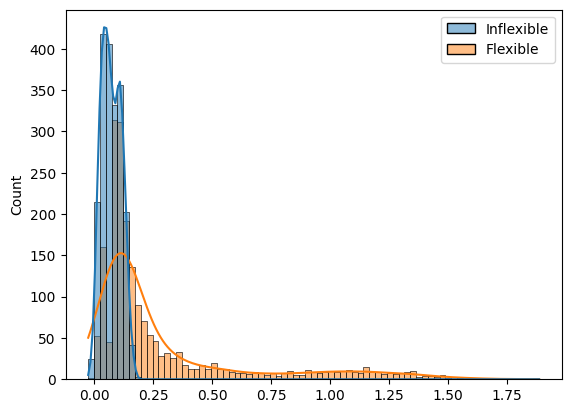

In [38]:
g = sns.histplot(
    data=irrs.drop(columns=['Difference']),
    binwidth=.025,
    kde=True
    )

<Axes: ylabel='Proportion'>

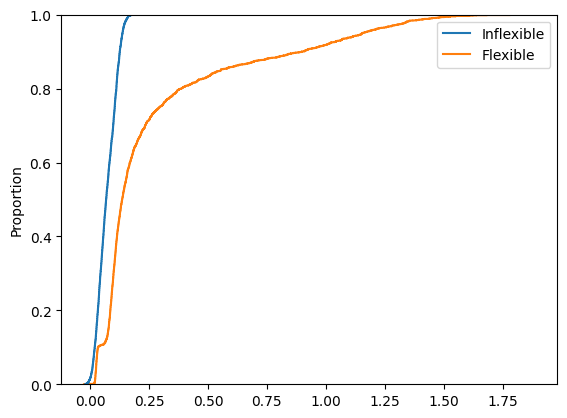

In [39]:
sns.ecdfplot(
    data=irrs.drop(columns=['Difference']))

#### IRRs x PVs
##### Inflexible Model

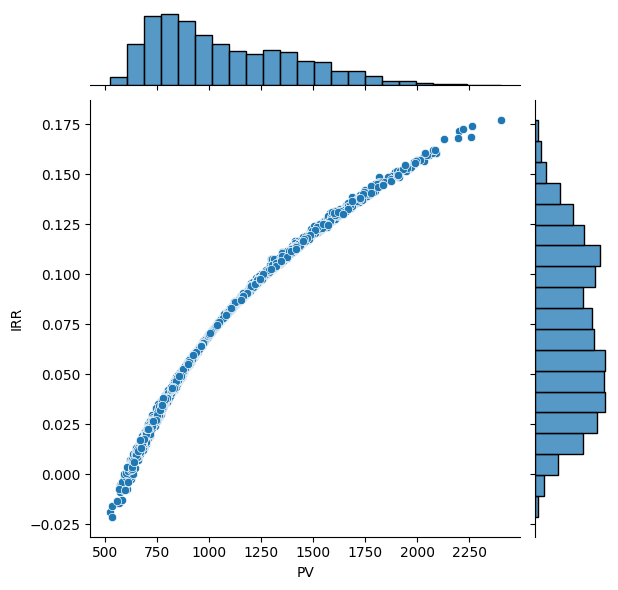

In [40]:
inflex_irr_x_pv = pd.DataFrame({
    'PV': inflex_pvs,
    'IRR': inflex_irrs,})
sns.jointplot(
    data=inflex_irr_x_pv,
    x='PV',
    y='IRR',
    kind='scatter')

##### Flexible Model

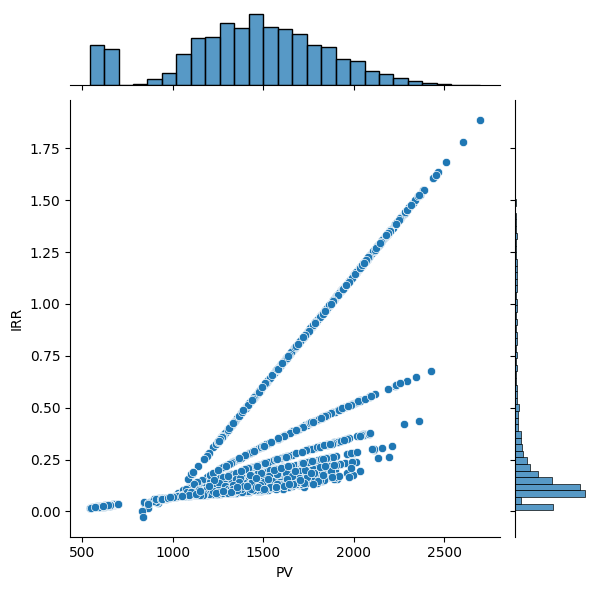

In [41]:
flex_irr_x_pv = pd.DataFrame({
    'PV': flex_pvs,
    'IRR': flex_irrs})
sns.jointplot(
    data=flex_irr_x_pv,
    x='PV',
    y='IRR',
    kind='scatter')

#### PVs Diffs
##### PV Difference as a function of Inflex PV


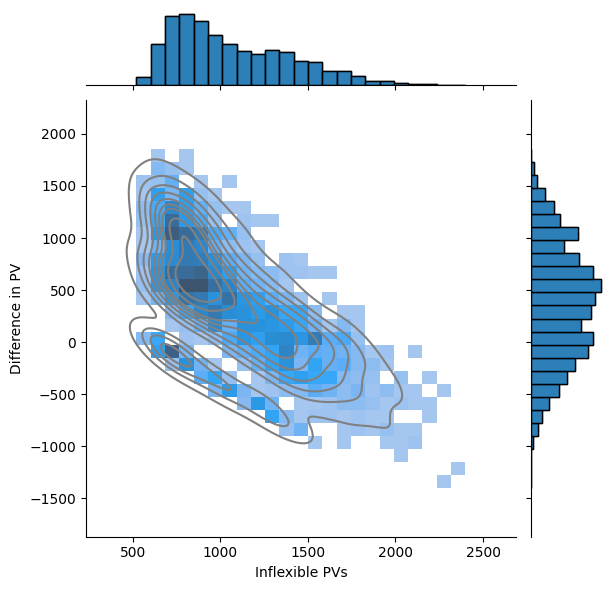

In [42]:
diff_pvs_x_inflex_pvs = pd.DataFrame({
    'Inflexible PVs': inflex_pvs,
    'Difference in PV': diff_pvs})
g = sns.jointplot(
    data=diff_pvs_x_inflex_pvs,
    x='Inflexible PVs',
    y='Difference in PV',
    kind='hist')
g.plot_joint(
    sns.kdeplot,
    color='grey',
    zorder=1,
    levels=10)
g.plot_marginals(
    sns.histplot
    )

##### IRR Difference as a function of Inflex IRR


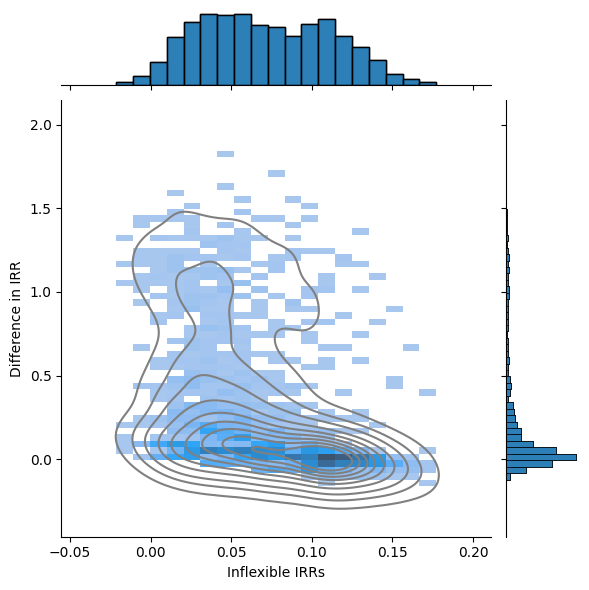

In [43]:
diff_irrs_x_inflex_irrs = pd.DataFrame({
    'Inflexible IRRs': inflex_irrs,
    'Difference in IRR': diff_irrs})
g = sns.jointplot(
    data=diff_irrs_x_inflex_irrs,
    x='Inflexible IRRs',
    y='Difference in IRR',
    kind='hist')
g.plot_joint(
    sns.kdeplot,
    color='grey',
    zorder=1,
    levels=10)
g.plot_marginals(
    sns.histplot
    )